In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Data
# Pastikan file 'time-series-19-covid-combined.csv' ada di direktori yang sama
df = pd.read_csv("time-series-19-covid-combined.csv")

# 2. Pra-pemrosesan Data: Fokus pada kasus global
# Agregasikan kasus harian untuk semua wilayah
df_global = df.groupby('Date')[['Confirmed', 'Recovered', 'Deaths']].sum().reset_index()

# 3. Hitung Variabel State (S, I, R)
# I (Infected): Kasus Aktif = Confirmed - Recovered - Deaths
df_global['Active_Infected'] = df_global['Confirmed'] - df_global['Recovered'].fillna(0) - df_global['Deaths']

# R (Removed): Kasus Sembuh/Hilang = Recovered + Deaths
df_global['Removed'] = df_global['Recovered'].fillna(0) + df_global['Deaths']

# S (Susceptible) membutuhkan total populasi (N). Kita asumsikan N = Total Populasi Dunia (misalnya 7.8 Miliar)
N = 7800000000  # Total Populasi Dunia (estimasi kasar)
df_global['Susceptible'] = N - df_global['Active_Infected'] - df_global['Removed']

# Pilih data yang akan digunakan untuk simulasi (misalnya 300 hari pertama)
df_sim = df_global.head(300).copy()

# Konversi kolom 'Date' menjadi hari ke-N
df_sim['Time_Days'] = np.arange(len(df_sim))

print("Data 5 Hari Pertama untuk Simulasi:")
# BARIS INI DIPERBAIKI: Menggunakan print standar df.head()
print(df_sim[['Time_Days', 'Active_Infected', 'Removed']].head()) 

# Tentukan Nilai Awal (y0)
I0 = df_sim['Active_Infected'].iloc[0]
R0 = df_sim['Removed'].iloc[0]
S0 = N - I0 - R0
Y0 = np.array([S0, I0, R0]) # Vektor [S, I, R] awal

Data 5 Hari Pertama untuk Simulasi:
   Time_Days  Active_Infected  Removed
0          0            510.0     45.0
1          1            606.0     48.0
2          2            879.0     62.0
3          3           1353.0     81.0
4          4           2010.0    108.0


In [3]:
# Model: Sistem Persamaan Diferensial Biasa (ODE) SIR
def sir_model(Y, t, N, beta, gamma):
    """
    Menghitung turunan dari S, I, dan R (Sistem PDB SIR).
    Y adalah vektor state: [S, I, R]
    """
    S, I, R = Y
    
    # dT/dt = f(T, t, k, Tenv) - Format standar fungsi ODE
    
    # 1. dS/dt: Laju penurunan rentan
    dSdt = -beta * S * I / N
    
    # 2. dI/dt: Laju perubahan terinfeksi
    dIdt = beta * S * I / N - gamma * I
    
    # 3. dR/dt: Laju peningkatan sembuh/hilang
    dRdt = gamma * I
    
    return np.array([dSdt, dIdt, dRdt])

In [4]:
def euler_method_sir(func, Y0, t_points, params):
    """
    Menerapkan Metode Euler untuk sistem 3 PDB (SIR).
    
    Argumen:
    func      : Fungsi turunan (sir_model)
    Y0        : Nilai awal (vektor [S0, I0, R0])
    t_points  : Array titik waktu (t_start, t_end, h)
    params    : Parameter tambahan untuk fungsi model (N, beta, gamma)
    """
    
    # Siapkan array kosong untuk menampung hasil
    S_points = np.zeros(len(t_points))
    I_points = np.zeros(len(t_points))
    R_points = np.zeros(len(t_points))
    
    # Masukkan nilai awal
    S_points[0], I_points[0], R_points[0] = Y0
    
    # Hitung step size (h) dari selisih dua titik waktu pertama
    h = t_points[1] - t_points[0]
    
    # Looping Iterasi
    for i in range(len(t_points) - 1):
        Y_current = np.array([S_points[i], I_points[i], R_points[i]])
        t_current = t_points[i]
        
        # 1. Hitung Slope (Kemiringan) saat ini
        # *params digunakan untuk membuka tuple parameter (N, beta, gamma)
        slopes = func(Y_current, t_current, *params)
        
        # 2. Hitung nilai berikutnya: Y_new = Y_old + h * slope
        Y_next = Y_current + h * slopes
        
        # Simpan nilai berikutnya
        S_points[i+1], I_points[i+1], R_points[i+1] = Y_next

    return S_points, I_points, R_points

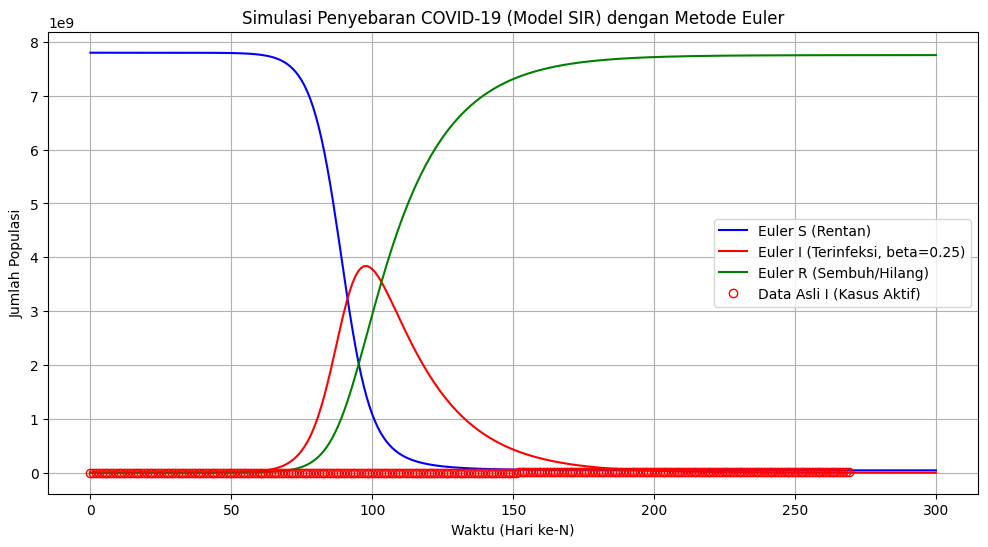


Mean Squared Error (MSE) untuk Kasus Aktif: 1,389,001,663,170,980,352.00


In [5]:
# 1. Parameter Simulasi (Estimasi Awal)
t_start = 0
t_end = 300 # Simulasi 300 hari
h = 1.0     # Step size: 1 hari
N_pop = N
beta = 0.25 # Laju penularan (Estimasi: Coba ubah nilai ini)
gamma = 0.05 # Laju pemulihan/penghilangan (Estimasi: Coba ubah nilai ini)

# Buat array waktu
t_points = np.arange(t_start, t_end + h, h)

# Parameter yang dikirim ke fungsi euler_method_sir
params_euler = (N_pop, beta, gamma)

# 2. Jalankan Euler
S_euler, I_euler, R_euler = euler_method_sir(sir_model, Y0, t_points, params_euler)

# 3. Visualisasi Hasil
plt.figure(figsize=(12, 6))

# Plot Simulasi Euler
plt.plot(t_points[:len(S_euler)], S_euler, 'b-', label='Euler S (Rentan)')
plt.plot(t_points[:len(I_euler)], I_euler, 'r-', label=f'Euler I (Terinfeksi, beta={beta})')
plt.plot(t_points[:len(R_euler)], R_euler, 'g-', label='Euler R (Sembuh/Hilang)')

# Plot Data Asli (Validasi)
plt.plot(df_sim['Time_Days'], df_sim['Active_Infected'], 'ro', markerfacecolor='none', label='Data Asli I (Kasus Aktif)')

plt.title('Simulasi Penyebaran COVID-19 (Model SIR) dengan Metode Euler')
plt.xlabel('Waktu (Hari ke-N)')
plt.ylabel('Jumlah Populasi')
plt.legend()
plt.grid(True)
plt.show()

# 4. Hitung Metrik Error (Mean Squared Error - MSE)
# Kita bandingkan I_euler dengan Data Asli I
I_data_sim = df_sim['Active_Infected'].values
I_euler_sim = I_euler[:len(I_data_sim)]

# Pastikan panjang array sama sebelum menghitung error
if len(I_data_sim) == len(I_euler_sim):
    mse = np.mean((I_data_sim - I_euler_sim)**2)
    print(f"\nMean Squared Error (MSE) untuk Kasus Aktif: {mse:,.2f}")
else:
    print("\nPerhatian: Panjang data asli dan simulasi berbeda. Cek Step Size atau durasi.")